# Streaky-ness 🔥

🏀 In this doc, I've created a new data set gathering each player's streaks per game. I worked from the [raw shot logs data in this repo](https://github.com/jessimk/LBJ_Make_or_Miss/blob/master/data/shot_logs_raw.csv).

📚 Part of the fun here has been continued practice with dictionaries and pandas. There's also EDA for the most 🔥 players, sorted by streak type. 

TODO:

The next addition here will be moving forward with some hypothesis testing and possibly some interactive plots.

In [73]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import time

### Wrangling


In [74]:
data = pd.read_csv("https://raw.githubusercontent.com/UBC-MDS/DSCI-522-Jes-Alex/master/data/shot_logs_raw.csv")

In [75]:

#filling in buzzer shots in the shot clock col
data = data.fillna(0)
data.head(5)

,GAME_ID,MATCHUP,LOCATION,W,FINAL_MARGIN,SHOT_NUMBER,PERIOD,GAME_CLOCK,SHOT_CLOCK,DRIBBLES,...,SHOT_DIST,PTS_TYPE,SHOT_RESULT,CLOSEST_DEFENDER,CLOSEST_DEFENDER_PLAYER_ID,CLOSE_DEF_DIST,FGM,PTS,player_name,player_id
0,21400899,"MAR 04, 2015 - CHA @ BKN",A,W,24,1,1,1:09,10.8,2,...,7.7,2,made,"Anderson, Alan",101187,1.3,1,2,brian roberts,203148
1,21400899,"MAR 04, 2015 - CHA @ BKN",A,W,24,2,1,0:14,3.4,0,...,28.2,3,missed,"Bogdanovic, Bojan",202711,6.1,0,0,brian roberts,203148
2,21400899,"MAR 04, 2015 - CHA @ BKN",A,W,24,3,1,0:00,0.0,3,...,10.1,2,missed,"Bogdanovic, Bojan",202711,0.9,0,0,brian roberts,203148
3,21400899,"MAR 04, 2015 - CHA @ BKN",A,W,24,4,2,11:47,10.3,2,...,17.2,2,missed,"Brown, Markel",203900,3.4,0,0,brian roberts,203148
4,21400899,"MAR 04, 2015 - CHA @ BKN",A,W,24,5,2,10:34,10.9,2,...,3.7,2,missed,"Young, Thaddeus",201152,1.1,0,0,brian roberts,203148


In [76]:
data.describe()

,GAME_ID,FINAL_MARGIN,SHOT_NUMBER,PERIOD,SHOT_CLOCK,DRIBBLES,TOUCH_TIME,SHOT_DIST,PTS_TYPE,CLOSEST_DEFENDER_PLAYER_ID,CLOSE_DEF_DIST,FGM,PTS,player_id
count,1.280690e+05,128069.000000,128069.000000,128069.000000,128069.000000,128069.000000,128069.000000,128069.000000,128069.000000,128069.000000,128069.000000,128069.000000,128069.000000,128069.000000
mean,2.140045e+07,0.208723,6.506899,2.469427,11.912012,2.023355,2.765901,13.571504,2.264670,159038.487284,4.123015,0.452139,0.997314,157238.251247
std,2.578773e+02,13.233267,4.713260,1.139919,6.182215,3.477760,3.043682,8.888964,0.441159,78791.172947,2.756446,0.497706,1.130978,79362.389336
min,2.140000e+07,-53.000000,1.000000,1.000000,0.000000,0.000000,-163.600000,0.000000,2.000000,708.000000,0.000000,0.000000,0.000000,708.000000
25%,2.140023e+07,-8.000000,3.000000,1.000000,7.500000,0.000000,0.900000,4.700000,2.000000,101249.000000,2.300000,0.000000,0.000000,101162.000000
50%,2.140045e+07,1.000000,5.000000,2.000000,12.000000,1.000000,1.600000,13.700000,2.000000,201949.000000,3.700000,0.000000,0.000000,201939.000000
75%,2.140067e+07,9.000000,9.000000,3.000000,16.400000,2.000000,3.700000,22.500000,3.000000,203079.000000,5.300000,1.000000,2.000000,202704.000000
max,2.140091e+07,53.000000,38.000000,7.000000,24.000000,32.000000,24.900000,47.200000,3.000000,530027.000000,53.200000,1.000000,3.000000,204060.000000


#### Wrangling Streaks

In [77]:
def calc_streak(data):
    
    #initialize empty list, counter and iterator
    streak = []
    count = 0
    iteration = 0
    
    for shot in data:
        iteration +=1
        
        #if it's the last shot in the set and it's a successfull shot, count it.
        if iteration == len(data) and shot == 1:
            count +=1
            streak.append(count)
        
        #if it's a sucessful shot, count it. 
        elif shot == 1:
            count +=1
        
        #oherwise pass and re-start the streak counter
        elif shot == 0:

            streak.append(count)
            count = 0
            
    return streak

In [78]:
%%time
game_streaks = {}
for player in data["player_name"].unique():
    
    game_streaks[player] = {}
    
    for game in data[(data.player_name == player)]["GAME_ID"].unique():

        game_shots = list(data[(data.player_name == player) &
                               (data.GAME_ID == game)
                              ]['FGM'])

        game_streaks[player][game] = {"name":player,
                                      "game":game,
                                      "shots" : game_shots,
                                      "FGA": len(game_shots),
                                      "FGM": sum(game_shots),
                                      "W" : data[(data.GAME_ID == game)].W.values[0],
                                      "first_shot": game_shots[0]
                                     }
        streaks_tmp = calc_streak(game_shots)
        shot_streak, total = np.unique(streaks_tmp, return_counts=True)

        streaks_tmp_dict = dict(zip(shot_streak, total))

        for k,v in streaks_tmp_dict.items():
            if k == 0 or k == 1:
                pass
            else:
                col_name = str(k)+"_streak"
                game_streaks[player][game][col_name] = v

    
    

CPU times: user 2min 41s, sys: 1.16 s, total: 2min 42s
Wall time: 2min 45s


In [79]:
frames = []

for player in data["player_name"].unique():
    frames.append(pd.DataFrame(game_streaks[player]).T)

In [80]:
streaks = pd.concat(frames, sort=True)
streaks = streaks.fillna(0)

In [108]:
streaks = streaks[(streaks.FGA > 1) & (streaks.FGA > 1)]
streaks['name'] = streaks['name'].apply(str.title)

In [109]:
streaks.head()

,10_streak,11_streak,13_streak,14_streak,2_streak,3_streak,4_streak,5_streak,6_streak,7_streak,8_streak,9_streak,FGA,FGM,W,first_shot,game,name,shots
21400899,0,0,0,0,0,0,0,0,0,0,0,0,9,2,W,1,21400899,Brian Roberts,"[1, 0, 0, 0, 0, 0, 0, 1, 0]"
21400890,0,0,0,0,1,0,0,0,0,0,0,0,4,2,W,0,21400890,Brian Roberts,"[0, 0, 1, 1]"
21400859,0,0,0,0,0,0,0,0,0,0,0,0,5,2,L,0,21400859,Brian Roberts,"[0, 1, 0, 0, 1]"
21400845,0,0,0,0,2,0,0,0,0,0,0,0,8,5,W,0,21400845,Brian Roberts,"[0, 1, 1, 0, 1, 0, 1, 1]"
21400827,0,0,0,0,0,0,0,0,0,0,0,0,4,0,L,0,21400827,Brian Roberts,"[0, 0, 0, 0]"


In [131]:
import plotly.plotly as py
import plotly.graph_objs as go
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot

init_notebook_mode(connected=True)

#### Streaky-ness EDA

In [110]:
n_shots = pd.DataFrame(streaks.groupby('name')['FGA'].sum())
made_shots = pd.DataFrame(streaks.groupby('name')['FGM'].sum())

In [111]:
streaks_list = np.arange(2,6,1)
streaks_dfs = {}

for streak_type in streaks_list:
    
    streak_name = str(streak_type)+"_streak"
    
    totals = pd.DataFrame(streaks.groupby('name')[streak_name].sum())
    totals.columns = ['total_' + streak_name]
    
    streak_temp = pd.concat([totals, n_shots, made_shots], axis=1).sort_values(by=totals.columns[0], ascending=False)
    streak_temp['FG%'] = streak_temp.FGM / streak_temp.FGA
    
    streaks_dfs[streak_name] = streak_temp

In [112]:
streaks_dfs["2_streak"].head(10)

,total_2_streak,FGA,FGM,FG%
name,,,,
Lebron James,76,978,478,0.488753
James Harden,73,1054,474,0.449715
Russell Westbrook,72,969,422,0.435501
Lamarcus Aldridge,72,1050,473,0.450476
Damian Lillard,72,986,426,0.432049
Stephen Curry,70,968,470,0.485537
Jimmy Butler,64,781,361,0.462228
Klay Thompson,64,971,449,0.462410
Demarcus Cousins,63,788,366,0.464467


In [113]:
streaks_dfs["3_streak"].head(10)

,total_3_streak,FGA,FGM,FG%
name,,,,
Blake Griffin,36,893,447,0.500560
Anthony Davis,36,841,457,0.543401
Klay Thompson,35,971,449,0.462410
Stephen Curry,34,968,470,0.485537
John Wall,33,874,392,0.448513
Derrick Favors,31,677,369,0.545052
Lebron James,30,978,478,0.488753
Lamarcus Aldridge,30,1050,473,0.450476
Nikola Vucevic,29,902,480,0.532151


In [114]:
streaks_dfs["4_streak"].head(10)

,total_4_streak,FGA,FGM,FG%
name,,,,
Nikola Vucevic,23,902,480,0.532151
Chris Paul,19,885,425,0.480226
Joe Johnson,16,767,335,0.436767
Markieff Morris,16,830,388,0.467470
Damian Lillard,16,986,426,0.432049
Al Horford,15,715,387,0.541259
James Harden,15,1054,474,0.449715
Tyson Chandler,14,338,229,0.677515
Paul Millsap,14,754,358,0.474801


In [115]:
streaks_dfs["5_streak"].head(10)

,total_5_streak,FGA,FGM,FG%
name,,,,
Rudy Gay,9,878,391,0.445330
Anthony Davis,9,841,457,0.543401
Mnta Ellis,9,1051,473,0.450048
Deandre Jordan,8,393,280,0.712468
Nikola Vucevic,8,902,480,0.532151
Carmelo Anthony,8,792,349,0.440657
Jordan Hill,8,614,285,0.464169
Brook Lopez,8,631,308,0.488114
Amare Stoudemire,7,336,185,0.550595


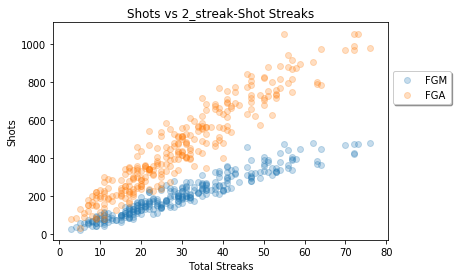

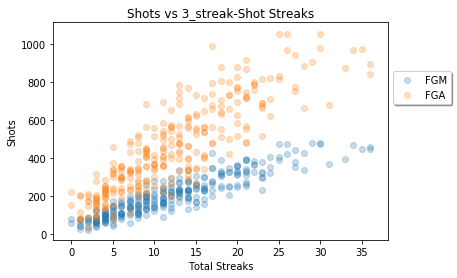

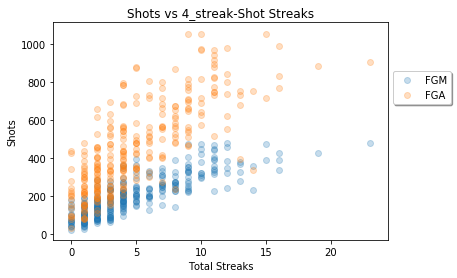

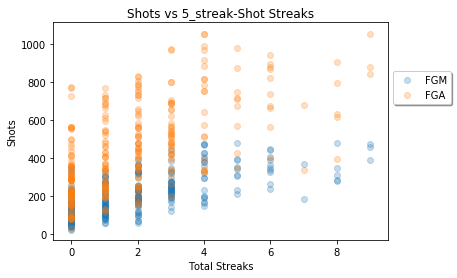

In [120]:
for streak_type in streaks_list:
    
    streak_name = str(streak_type)+"_streak"
    
    plt.scatter(streaks_dfs[streak_name][streaks_dfs[streak_name].columns[0]], 
                streaks_dfs[streak_name].FGM, alpha=0.25,
               label="FGM")

    plt.scatter(streaks_dfs[streak_name][streaks_dfs[streak_name].columns[0]], 
                streaks_dfs[streak_name].FGA, alpha=0.25,
               label="FGA")

    plt.legend(loc='upper center', 
               bbox_to_anchor=(1.1, 0.8), 
               shadow=True, ncol=1)

    plt.xlabel("Total Streaks")
    plt.ylabel("Shots")

    plt.title("Shots vs "+str(streak_name)+"-Shot Streaks")

    plt.show()

#### playing with interactive plots

In [130]:
data = [
    go.Scatter(
        x = streaks_dfs["2_streak"].iloc[:,0],
        y = streaks_dfs["2_streak"].iloc[:,3],
        mode = 'markers',
        hovertext = streaks_dfs["2_streak"].index,
        
        hoverinfo = 'text',
        
        showlegend = False
    )
]

layout = {
    "hovermode" : "closest",
    "title" : "2-Shot Streaks vs. Shooting Percentage",
    "xaxis": {
        "title" : "Number of 2-Shot Streaks"
    },
    "yaxis": {
        "title" : "FG%"
    }
}


figure=go.Figure(data=data,layout=layout)

py.iplot(figure, filename="2_streak_hover")

High five! You successfully sent some data to your account on plotly. View your plot in your browser at https://plot.ly/~jessimk/0 or inside your plot.ly account where it is named '2_streak_hover'
